In [2]:
from os.path import join, exists
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import h5py
import os
import pandas as pd
import logging
import networkx as nx

from multicamera_airflow_pipeline.tim_240731.keypoints.triangulation import Triangulator
import multicam_calibration as mcc

# set logging level to info
logging.basicConfig(level=logging.INFO)



Python interpreter binary location: /home/jop9552/miniconda3/envs/dataPy_NWB2/bin/python


In [10]:
logging.basicConfig(level=logging.INFO)

# Funcs

In [11]:

def add_text(im, text, position):
    im = cv2.putText(
        im,
        text,
        position,
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (255, 255, 255),
        1,
        cv2.LINE_AA,
    )
    return im


def build_node_hierarchy(bodyparts, skeleton, root_node):
    """
    Define a rooted hierarchy based on the edges of a spanning tree.

    Parameters
    ----------
    bodyparts: list of str
        Ordered list of node names.

    skeleton: list of tuples
        Edges of the spanning tree as pairs of node names.

    root_node: str
        The desired root node of the hierarchy

    Returns
    -------
    node_order: array of shape (num_nodes,)
        Integer array specifying an ordering of nodes in which parents
        precede children (i.e. a topological ordering).

    parents: array of shape (num_nodes,)
        Child-parent relationships using the indexes from `node_order`,
        such that `parent[i]==j` when `node_order[j]` is the parent of
        `node_order[i]`.

    Raises
    ------
    ValueError
        The edges in `skeleton` do not define a spanning tree.
    """
    G = nx.Graph()
    G.add_nodes_from(bodyparts)
    G.add_edges_from(skeleton)

    if not nx.is_tree(G):
        cycles = list(nx.cycle_basis(G))
        raise ValueError(
            "The skeleton does not define a spanning tree, "
            "as it contains the following cycles: {}".format(cycles)
        )

    if not nx.is_connected(G):
        raise ValueError(
            "The skeleton does not define a spanning tree, "
            "as it contains multiple connected components."
        )

    node_order = list(nx.dfs_preorder_nodes(G, root_node))
    parents = np.zeros(len(node_order), dtype=int)

    for i, j in skeleton:
        i, j = node_order.index(i), node_order.index(j)
        if i < j:
            parents[j] = i
        else:
            parents[i] = j

    node_order = np.array([bodyparts.index(n) for n in node_order])
    return node_order, parents


def get_edges(use_bodyparts, skeleton):
    """Represent the skeleton as a list of index-pairs.

    Parameters
    -------
    use_bodyparts: list
        Bodypart names

    skeleton: list
        Pairs of bodypart names as tuples (bodypart1,bodypart2)

    Returns
    -------
    edges: list
        Pairs of indexes representing the enties of `skeleton`
    """
    edges = []
    if len(skeleton) > 0:
        if isinstance(skeleton[0][0], int):
            edges = skeleton
        else:
            assert use_bodyparts is not None, fill(
                "If skeleton edges are specified using bodypart names, "
                "`use_bodyparts` must be specified"
            )

            for bp1, bp2 in skeleton:
                if bp1 in use_bodyparts and bp2 in use_bodyparts:
                    edges.append(
                        [use_bodyparts.index(bp1), use_bodyparts.index(bp2)]
                    )
    return edges


def crop_image(image, centroid, crop_size):
    """Crop an image around a centroid.

    Parameters
    ----------
    image: ndarray of shape (height, width, 3)
        Image to crop.

    centroid: tuple of int
        (x,y) coordinates of the centroid.

    crop_size: int or tuple(int,int)
        Size of the crop around the centroid. Either a single int for a square
        crop, or a tuple of ints (w,h) for a rectangular crop.


    Returns
    -------
    image: ndarray of shape (crop_size, crop_size, 3)
        Cropped image.
    """
    if isinstance(crop_size, tuple):
        w, h = crop_size
    else:
        w, h = crop_size, crop_size
    x, y = int(centroid[0]), int(centroid[1])

    x_min = max(0, x - w // 2)
    y_min = max(0, y - h // 2)
    x_max = min(image.shape[1], x + w // 2)
    y_max = min(image.shape[0], y + h // 2)

    cropped = image[y_min:y_max, x_min:x_max]
    padded = np.zeros((h, w, *image.shape[2:]), dtype=image.dtype)
    pad_x = max(w // 2 - x, 0)
    pad_y = max(h // 2 - y, 0)
    padded[pad_y : pad_y + cropped.shape[0], pad_x : pad_x + cropped.shape[1]] = cropped
    return padded


def overlay_keypoints_on_image(
    image,
    coordinates,
    edges=[],
    keypoint_colormap="autumn",
    keypoint_colors=None,
    node_size=5,
    line_width=2,
    copy=False,
    opacity=1.0,
):
    """Overlay keypoints on an image.

    Parameters
    ----------
    image: ndarray of shape (height, width, 3)
        Image to overlay keypoints on.

    coordinates: ndarray of shape (num_keypoints, 2)
        Array of keypoint coordinates.

    edges: list of tuples, default=[]
        List of edges that define the skeleton, where each edge is a
        pair of indexes.

    keypoint_colormap: str, default='autumn'
        Name of a matplotlib colormap to use for coloring the keypoints.

    keypoint_colors : array-like, shape=(num_keypoints,3), default=None
        Color for each keypoint. If None, the keypoint colormap is used.
        If the dtype is int, the values are assumed to be in the range 0-255,
        otherwise they are assumed to be in the range 0-1.

    node_size: int, default=5
        Size of the keypoints.

    line_width: int, default=2
        Width of the skeleton lines.

    copy: bool, default=False
        Whether to copy the image before overlaying keypoints.

    opacity: float, default=1.0
        Opacity of the overlay graphics (0.0-1.0).

    Returns
    -------
    image: ndarray of shape (height, width, 3)
        Image with keypoints overlayed.
    """
    if copy or opacity < 1.0:
        canvas = image.copy()
    else:
        canvas = image

    if keypoint_colors is None:
        cmap = plt.colormaps[keypoint_colormap]
        colors = np.array(cmap(np.linspace(0, 1, coordinates.shape[0])))[:, :3]
    else:
        colors = np.array(keypoint_colors)

    if isinstance(colors[0, 0], float):
        colors = [tuple([int(c) for c in cs * 255]) for cs in colors]

    # overlay skeleton
    for i, j in edges:
        if np.isnan(coordinates[i, 0]) or np.isnan(coordinates[j, 0]):
            continue
        pos1 = (int(coordinates[i, 0]), int(coordinates[i, 1]))
        pos2 = (int(coordinates[j, 0]), int(coordinates[j, 1]))
        canvas = cv2.line(canvas, pos1, pos2, colors[i], line_width, cv2.LINE_AA)

    # overlay keypoints
    for i, (x, y) in enumerate(coordinates):
        if np.isnan(x) or np.isnan(y):
            continue
        pos = (int(x), int(y))
        canvas = cv2.circle(canvas, pos, node_size, colors[i], -1, lineType=cv2.LINE_AA)

    if opacity < 1.0:
        image = cv2.addWeighted(image, 1 - opacity, canvas, opacity, 0)
    return image


In [12]:
# this is the order that we get keypoints from the hrnet
bodyparts_hrnet_ordering = [
    "tail_tip",
    "tail_base",
    "spine_low",
    "spine_mid",
    "spine_high",
    "left_ear",
    "right_ear",
    "forehead",
    "nose_tip",
    "left_hind_paw_front",
    "left_hind_paw_back",
    "right_hind_paw_front",
    "right_hind_paw_back",
    "left_fore_paw",
    "right_fore_paw",
]

# When we pass the keypoints to the gimbal, we need to reorder them
# in order to respect the "node hierarchy" that gimbal requires.
# This is the order that they come out of gimbal in.
bodyparts_gimbal_ordering = [
    "spine_low",
    "tail_base",
    "spine_mid",
    "spine_high",
    "left_ear",
    "right_ear",
    "forehead",
    "nose_tip",
    "left_fore_paw",
    "right_fore_paw",
    "left_hind_paw_back",
    "left_hind_paw_front",
    "right_hind_paw_back",
    "right_hind_paw_front",
]

skeleton = [
    ["tail_base", "spine_low"],
    ["spine_low", "spine_mid"],
    ["spine_mid", "spine_high"],
    ["spine_high", "left_ear"],
    ["spine_high", "right_ear"],
    ["spine_high", "forehead"],
    ["forehead", "nose_tip"],
    ["left_hind_paw_back", "left_hind_paw_front"],
    ["spine_low", "left_hind_paw_back"],
    ["right_hind_paw_back", "right_hind_paw_front"],
    ["spine_low", "right_hind_paw_back"],
    ["spine_high", "left_fore_paw"],
    ["spine_high", "right_fore_paw"],
]


use_bodyparts = bodyparts_hrnet_ordering[1:] # we exclude the tail tip from downstream analysis
use_bodyparts_ix = np.array(
    [bodyparts_hrnet_ordering.index(bp) for bp in use_bodyparts]
)
edges = np.array(get_edges(use_bodyparts, skeleton))
node_order, parents = build_node_hierarchy(use_bodyparts, skeleton, "spine_low")
edges = np.argsort(node_order)[edges]

# Setup

In [13]:
kp_dir = "/n/groups/datta/Jonah/20240125_CoA_hM4Di/20240515_CoA_6cam_odors/data/J04302/20240528_J04302/"
kp_files = glob(join(kp_dir, "*keypoints.h5"))
# camera_names = [f.split(".")[1] for f in kp_files]
camera_names = ['top', 'side1', 'side2', 'side3', 'side4', 'bottom']  # this is the order from the calibration
kp_files = [f for c in camera_names for f in kp_files if c in f]
vid_names = [f.replace(".keypoints.h5", ".mp4") for f in kp_files]
centroid_files = [f.replace(".keypoints.h5", ".centroid.npy") for f in kp_files]
triang_file = glob(join(kp_dir, "*triangulation.npy"))[0]
calibration_file = "/n/groups/datta/Jonah/2024_6cam_calibrations/JP_219_rig/calibration/20240529_calibration/20240529_calibration.camera_params.h5"
kp_files = dict(zip(camera_names, kp_files))
kp_files

{'top': '/n/groups/datta/Jonah/20240125_CoA_hM4Di/20240515_CoA_6cam_odors/data/J04302/20240528_J04302/20240528_J04302.top.0.keypoints.h5',
 'side1': '/n/groups/datta/Jonah/20240125_CoA_hM4Di/20240515_CoA_6cam_odors/data/J04302/20240528_J04302/20240528_J04302.side1.0.keypoints.h5',
 'side2': '/n/groups/datta/Jonah/20240125_CoA_hM4Di/20240515_CoA_6cam_odors/data/J04302/20240528_J04302/20240528_J04302.side2.0.keypoints.h5',
 'side3': '/n/groups/datta/Jonah/20240125_CoA_hM4Di/20240515_CoA_6cam_odors/data/J04302/20240528_J04302/20240528_J04302.side3.0.keypoints.h5',
 'side4': '/n/groups/datta/Jonah/20240125_CoA_hM4Di/20240515_CoA_6cam_odors/data/J04302/20240528_J04302/20240528_J04302.side4.0.keypoints.h5',
 'bottom': '/n/groups/datta/Jonah/20240125_CoA_hM4Di/20240515_CoA_6cam_odors/data/J04302/20240528_J04302/20240528_J04302.bottom.0.keypoints.h5'}

In [14]:
camera_names

['top', 'side1', 'side2', 'side3', 'side4', 'bottom']

In [15]:
conf_threshold = 0.25  # has been 0.25

## Load the data for this session

In [16]:
alignment_file = join(kp_dir, "aligned_frame_numbers.csv")
if not exists(alignment_file):
    print(f"Assuming all videos have the same number of frames. If this is not the case, please provide an alignment file at {alignment_file}.")
    do_alignment = False
else:
    align_df = pd.read_csv(alignment_file)  # cols are top, bottom, side1, ..., side4, trigger_number
    max_n_frames = align_df.shape[0]
    do_alignment = True

In [17]:
all_centroids = {}
all_uvs = {}
for cam, kp_file in kp_files.items():

    # Load centroids
    centroids = np.load(centroid_files[camera_names.index(cam)])

    # Load keypoints
    with h5py.File(kp_file, "r") as h5:
        uvs = h5["uv"][()][:, use_bodyparts_ix][:, node_order]
        confs = h5["conf"][()][:, use_bodyparts_ix][:, node_order]

    # Replace low confidence detections with nan
    uvs[confs < conf_threshold] = np.nan  
    
    # Frame alignment
    aligned_centroids = np.nan * np.zeros((max_n_frames, centroids.shape[1]))
    aligned_confs = np.nan * np.zeros((max_n_frames, confs.shape[1]))
    aligned_uvs = np.nan * np.zeros((max_n_frames, uvs.shape[1], uvs.shape[2]))
    align_vec = align_df[cam].values
    aligned_confs[~pd.isnull(align_vec), ...] = confs
    aligned_uvs[~pd.isnull(align_vec), ...] = uvs
    aligned_centroids[~pd.isnull(align_vec), ...] = centroids

    all_centroids[cam] = aligned_centroids
    all_uvs[cam] = aligned_uvs

# Load triangulation data
triang_data = np.load(triang_file, allow_pickle=True)  # nframes x nkeypoints x 3
triang_data = triang_data[:, use_bodyparts_ix][:, node_order]

# Load camera calibration data
all_extrinsics, all_intrinsics, _ = mcc.load_calibration(
    calibration_file, "gimbal"
)

print([uvs.shape for _,uvs in all_uvs.items()])
print(triang_data.shape)

DEBUG:h5py._conv:Creating converter from 3 to 5


[(144005, 14, 2), (144005, 14, 2), (144005, 14, 2), (144005, 14, 2), (144005, 14, 2), (144005, 14, 2)]
(144005, 14, 3)


## Find frames to work with

In [18]:
import videochef as vc

In [19]:
"""
Frame 1046
"""

'\nFrame 1046\n'

In [20]:
class FrameRetriever():
    """Implement simple caching for frame retrieval.
    Probably best to not use this with entire videos, only when you know you'll be using a small set of frames.
    """
    def __init__(self, video_file):
        self.video_file = video_file
        self.frame_dict = {}
    
    def get_frame(self, frame_number):
        if frame_number not in self.frame_dict:
            self.frame_dict[frame_number] = self.read_frame(frame_number)
        return self.frame_dict[frame_number]

    def read_frame(self, frame_number):
        with vc.io.VideoReader(self.video_file, frame_ixs=[frame_number]) as vr:
            return next(vr)

class RawTriangRetriever():
    """Implement simple caching for triangulation retrieval.
    Probably best to not use this with entire videos, only when you know you'll be using a small set of frames.
    """
    def __init__(self, raw_3d_triang_data, camera_list, intrinsics, extrinsics):
        self.raw_3d_triang_data = raw_3d_triang_data
        self.camera_list = camera_list
        self.intrinsics = {c: i for c, i in zip(camera_list, intrinsics)}
        self.extrinsics = {c: e for c, e in zip(camera_list, extrinsics)}
        self.reproj_dict = {}
        
    def get_triang_reprojection(self, frame_number, camera):
        key = (frame_number, camera)
        if key not in self.reproj_dict:
            self.reproj_dict[key] = self.reproject_triang(frame_number, camera)
        return self.reproj_dict[key]

    def reproject_triang(self, frame_number, camera):
        raw_3d = self.raw_3d_triang_data[frame_number]
        intr = self.intrinsics[camera]
        extr = self.extrinsics[camera]
        triang = mcc.project_points(raw_3d, extr, *intr)
        return triang
        

In [21]:
crop_size = 384

In [22]:
logging.basicConfig(level=logging.INFO)

In [23]:
frame_dict = {}
for iCam, cam in enumerate(camera_names):
    frame_dict[cam] = FrameRetriever(vid_names[iCam])
TriangRetriever = RawTriangRetriever(triang_data, camera_names, all_intrinsics, all_extrinsics)

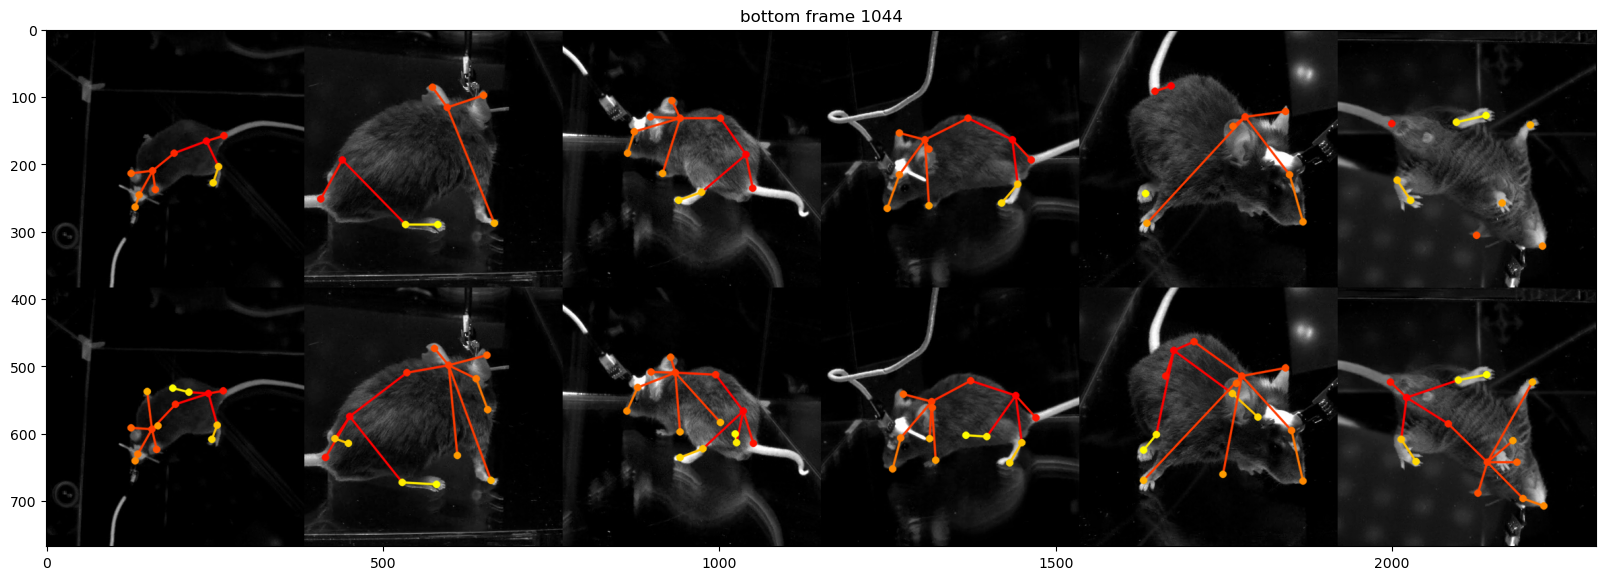

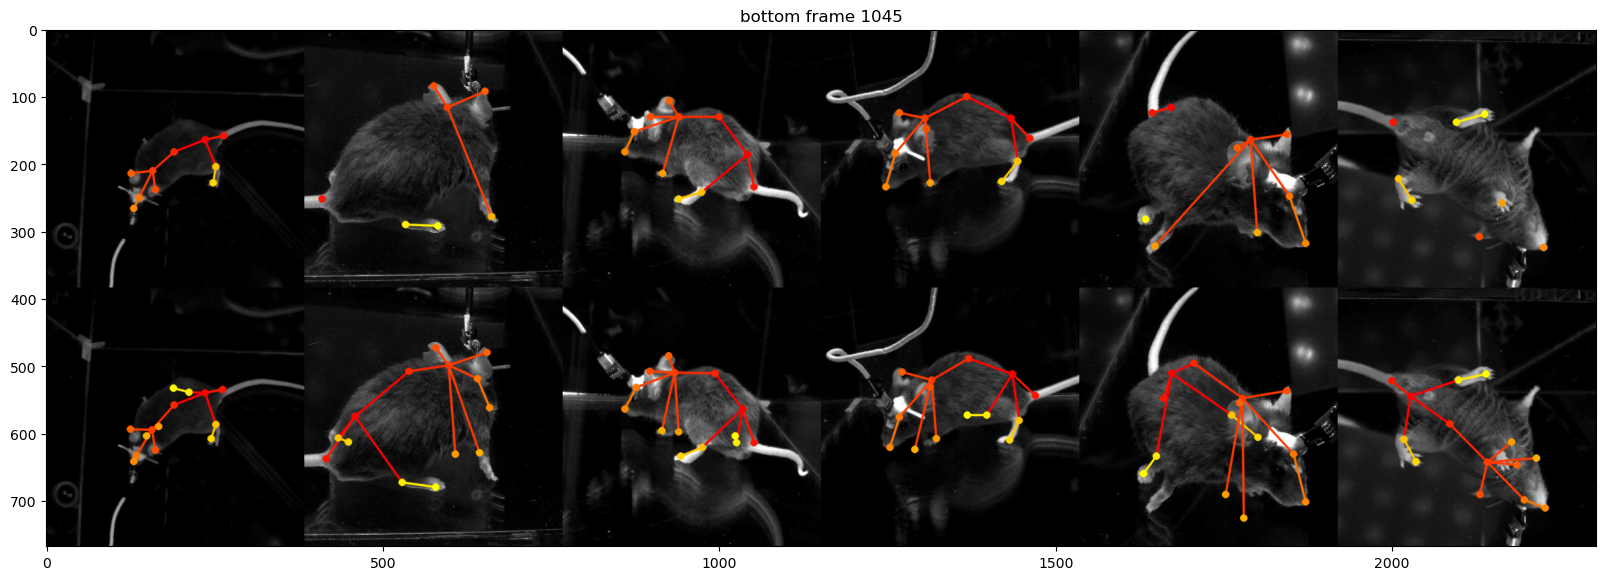

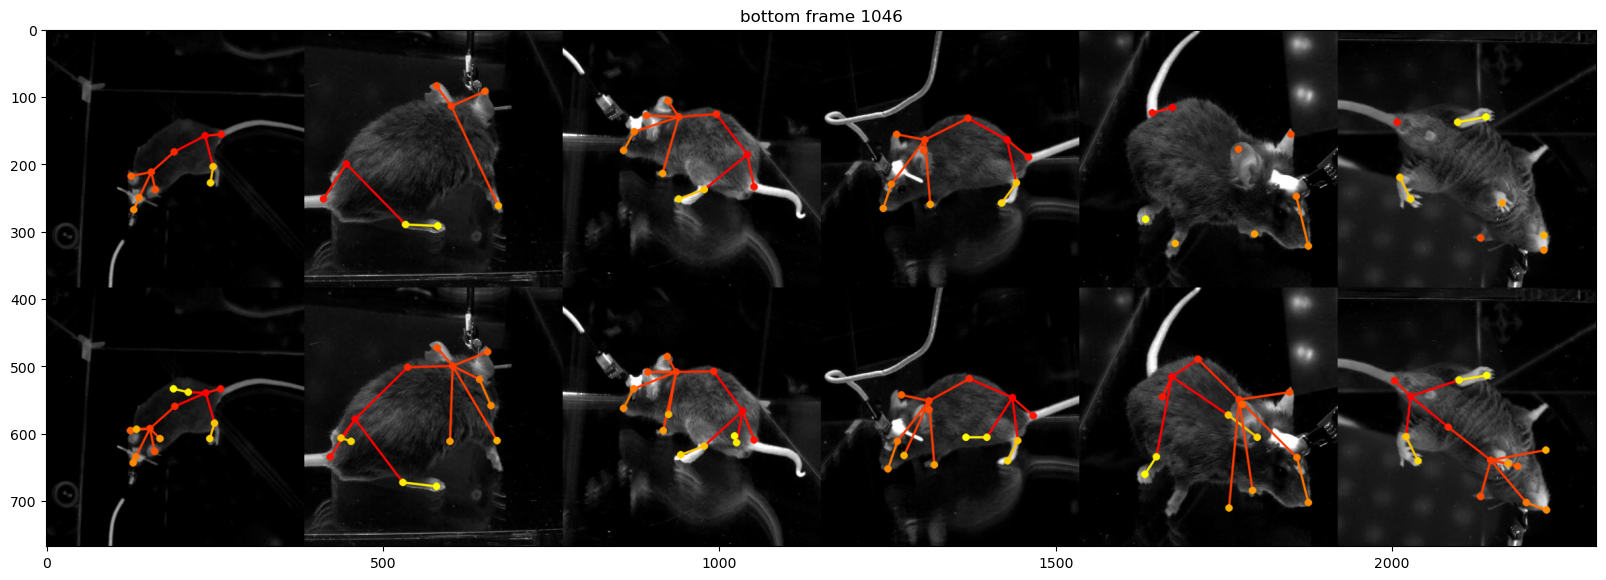

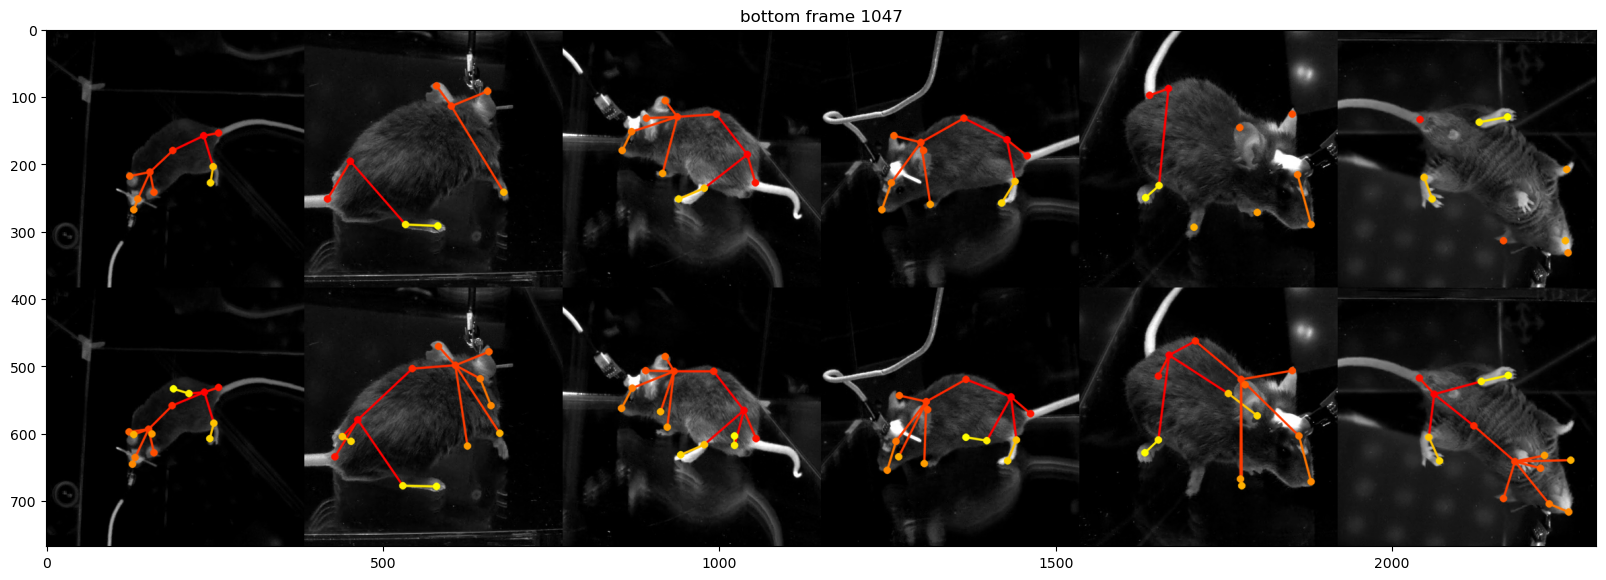

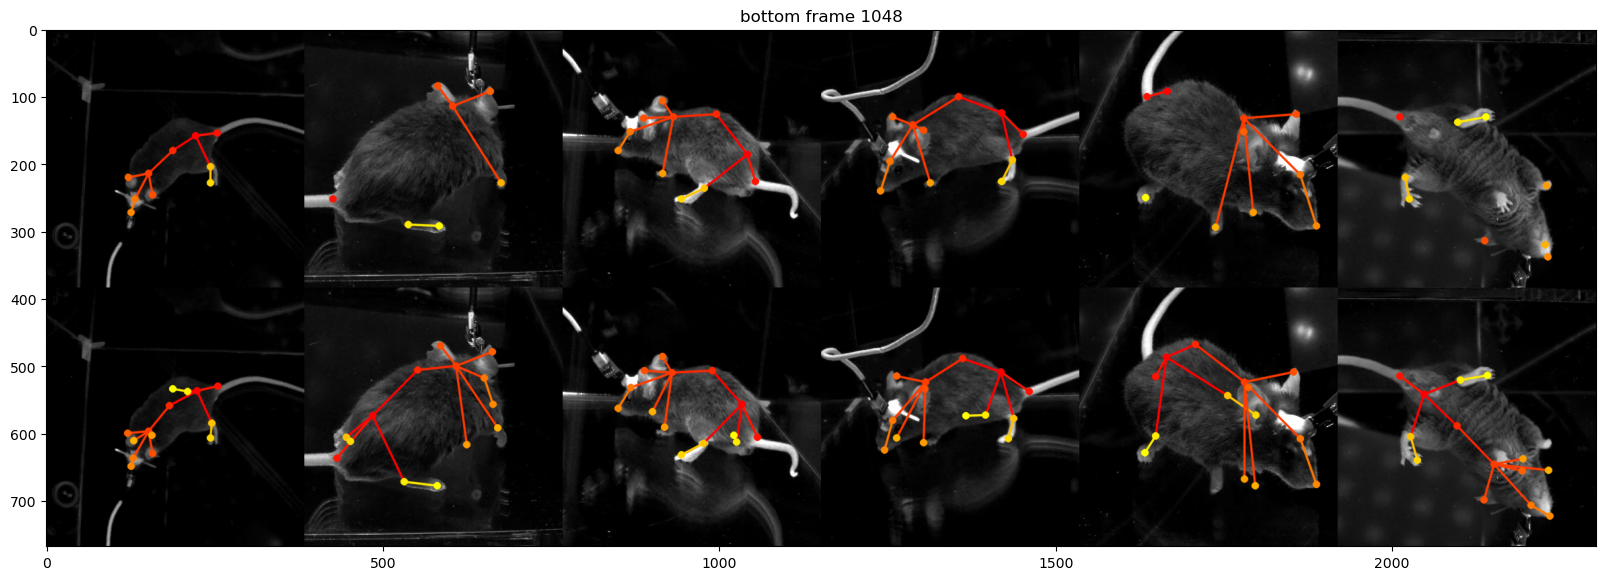

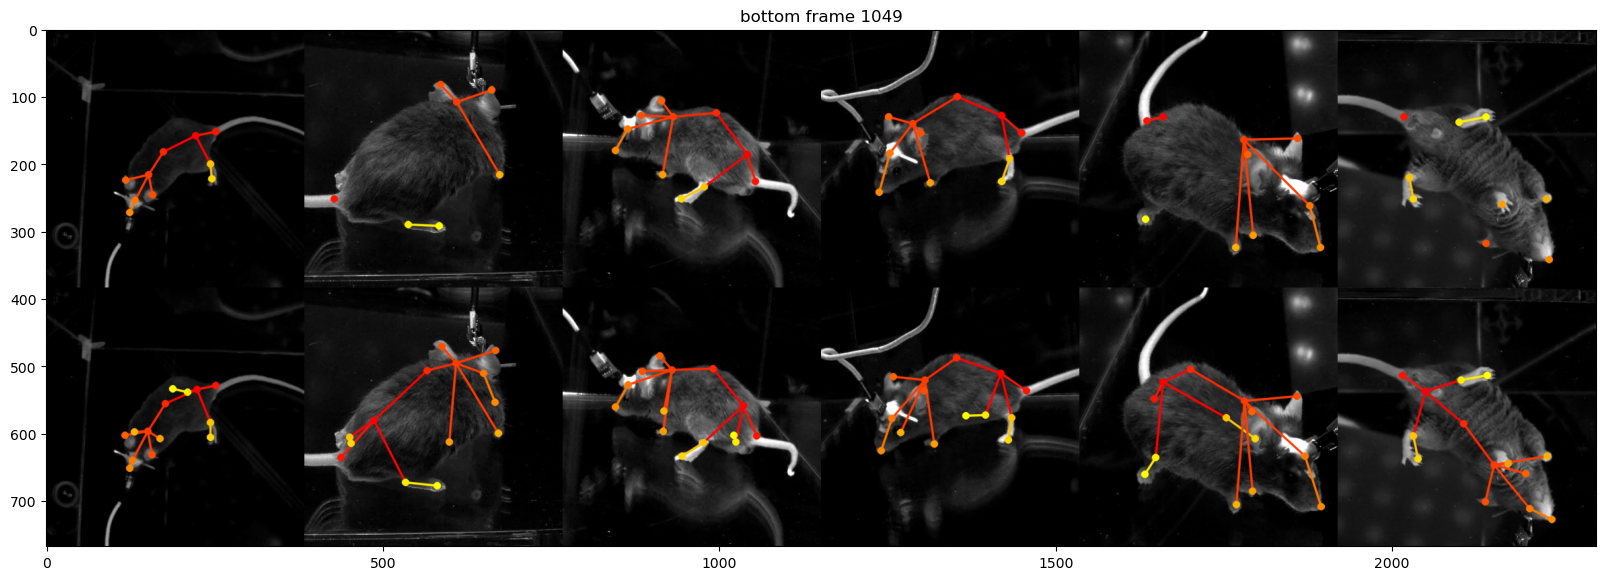

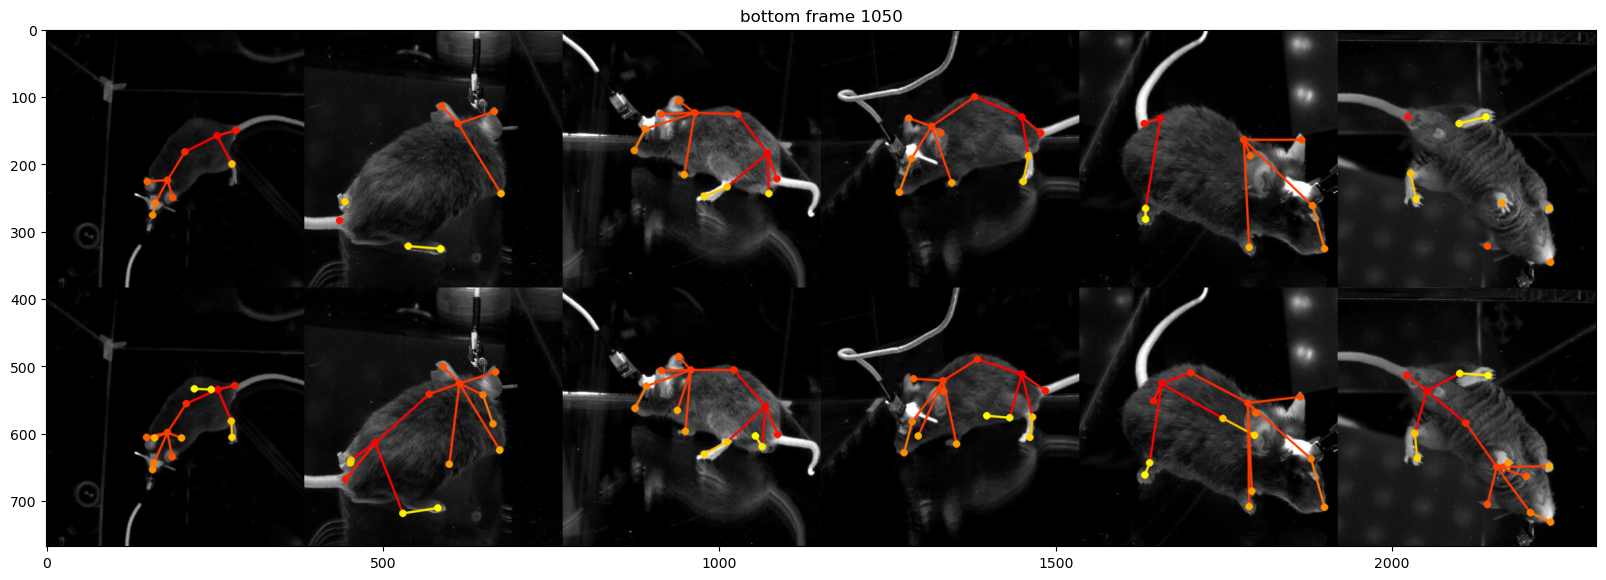

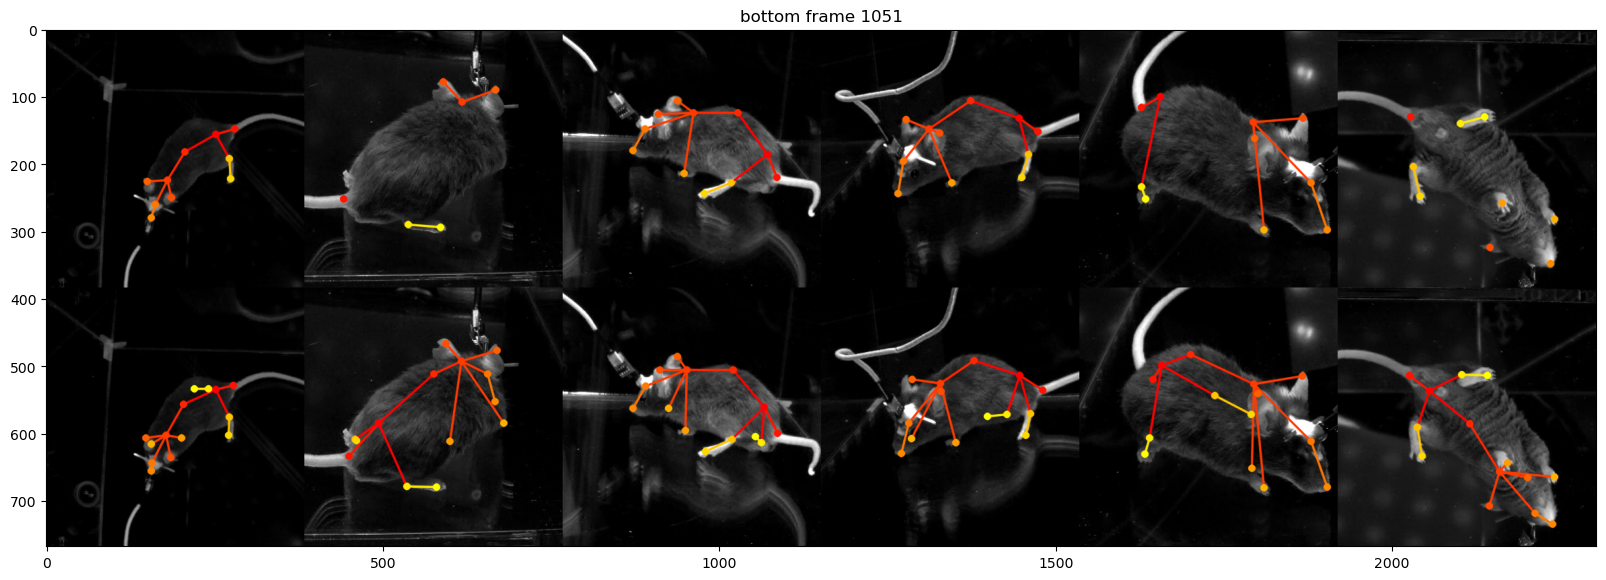

In [26]:
frame_ixs = [
1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051
# 2230, 2231
]

for iFrame, (frame_ix) in enumerate(frame_ixs):
    hrnet_row = []
    triang_row = []
    for iCam, cam in enumerate(camera_names):
        
        # Retrieve frame, using cached frames
        frame = frame_dict[cam].get_frame(frame_ix)

        # Retrieve reprojected triangulation data, using cached triangulated data
        raw_triang = TriangRetriever.get_triang_reprojection(frame_ix, cam)
        
        # Make hrnet keypoint img
        base_im = frame.copy()
        frame_uvs = all_uvs[cam][frame_ix, ...]
        im = overlay_keypoints_on_image(base_im, frame_uvs, edges)
        im = crop_image(im, all_centroids[cam][frame_ix], crop_size)
        hrnet_row.append(im)

        # Make triangulation keypoint img
        base_im = frame.copy()
        im = overlay_keypoints_on_image(base_im, raw_triang, edges)
        im = crop_image(im, all_centroids[cam][frame_ix], crop_size)
        triang_row.append(im)
        
    hrnet_row = np.hstack(hrnet_row)
    triang_row = np.hstack(triang_row)
    full = np.vstack([hrnet_row, triang_row])
    plt.figure(figsize=(20, 20))
    plt.imshow(full)
    plt.title(f"{cam} frame {frame_ix}")
    plt.show()